<h1 align="center"> User viability </h1>

## 1. Business Understanding

In this kernel we will use various predictive models to see how accurate they  are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!

### Our Goals: 

* Understand the little distribution of the "little" data that was provided to us. </li>
* Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm) </li>
* Determine the Classifiers we are going to use and decide which one has a higher accuracy. </li>
* Create a Neural Network and compare the accuracy to our best classifier. </li>

<h2> Outline: </h2>
I. <b>Understanding our data</b><br>
a) [Gather Sense of our data](#gather)<br><br>

II. <b>Preprocessing</b><br>
a) [Scaling and Distributing](#distributing)<br>
b) [Splitting the Data](#splitting)<br><br>

III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>
b) [Anomaly Detection](#anomaly)<br>
c) [Dimensionality Reduction and Clustering (t-SNE)](#clustering)<br>
d) [Classifiers](#classifiers)<br>
e) [A Deeper Look into Logistic Regression](#logistic)<br>
f) [Oversampling with SMOTE](#smote)<br><br>

IV. <b>Testing </b><br>
a) [Testing with Logistic Regression](#testing_logistic)<br>
b) [Neural Networks Testing (Undersampling vs Oversampling)](#neural_networks)



## 2. Data Understanding
<a id="gather"></a>
The first thing we must do is gather a <b> basic sense </b> of our data. Remember, except for the <b>transaction</b> and <b>amount</b> we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.   

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

SEED = 42

c:\Users\user\.virtualenvs\habi_ia-jg5KU8bY\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
habi_df = pd.read_excel('dataset.xlsx')

In [3]:
habi_df.head()

,id,birth_date,terms_conditions,gender,meta,date_exp_token,id.1,contact_id,type_occupation_id,type_independent_activity_id,...,company_phone,company_city_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1767,1998-05-30,1,NaN,NaN,2022-11-25 23:13:29.0,5,1767,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,23963,1984-07-08,0,NaN,NaN,2023-01-16 18:16:50.0,4547,23963,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,23965,1985-02-14,0,NaN,NaN,NaN,4549,23965,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,24370,1997-01-09,0,NaN,NaN,NaN,4860,24370,1,1,...,NaN,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [6]:
print(habi_df.shape)
print(habi_df.columns)

(3944, 33)
Index(['id', 'birth_date', 'terms_conditions', 'gender', 'meta',
       'date_exp_token', 'id.1', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'type_profession_id',
       'type_contract_id', 'init_occupation_date', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'loan_required', 'defer_years',
       'region_id', 'company_nit', 'company_name', 'company_address',
       'company_phone', 'company_city_id', 'name', 'label', 'is_active',
       'activity_code', 'name.1', 'label.1', 'viability', 'is_selected'],
      dtype='object')


### Data Content

Voy a tratar de entender un poco las columnas usadas en este dataset, puede ser que las descripciones no sean acertadas pero esto puede generar una base para entender los datos y como deben ser tratados mas adelante.

**id:** ID del usuario

**birth_date:** Fecha de nacimiento del usuario

**terms_conditions:** Indica si el usuario aceptó los términos y condiciones

**gender:** Género del usuario

**meta:** Metadatos asociados a una transacción

**date_exp_token:** Fecha de expiración del token

**id.1**: ID de la ocupación del usuario

**contact_id:** ID del usuario - duplicado con "id

**type_occupation_id:** Tipo de ocupación del usuario

**type_independent_activity_id:** ID del tipo de actividad independiente

**type_profession_id:** ID del tipo de profesión

**type_contract_id:** ID del tipo de contrato

**init_occupation_date:** Fecha de inicio de la ocupación

**incomes:** Ingresos totales

**extra_incomes:** Ingresos extra

**familiar_debts:** Deudas relacionadas con la familia del usuario

**is_tax_return:** Indica si corresponde una declaración de impuestos

**loan_required:** Indica si se requiere un préstamo

**defer_years:** Número de años para los cuales se pospone el préstamo

**region_id:** ID de la región

**company_name:** Nombre de la empresa

**company_nit:** NIT (Número de Identificación Tributaria) 

**company_address:** Dirección de la empresa

**company_phone:** Número de teléfono de la empresa

**company_city_id:** ID de la ciudad donde se encuentra la empresa

**name:** nombre del reporte en ingles

**label:** nombre del reporte en español (duplicado con name)

**is_active:** Indica si el usuario está activo

**activity_code:** Código relacionado con una actividad específica

**name.1** : tipo de trabajo del usuario en ingles

**label.1** :tipo de trabajo del usuario en español (duplicado con name.1)

**viability:** Si el usuario es viable o no

**is_selected:** Si el usuario es seleccionado o no


In [7]:
habi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3944 non-null   int64  
 1   birth_date                    3900 non-null   object 
 2   terms_conditions              3944 non-null   int64  
 3   gender                        2 non-null      object 
 4   meta                          16 non-null     object 
 5   date_exp_token                2351 non-null   object 
 6   id.1                          3944 non-null   int64  
 7   contact_id                    3944 non-null   int64  
 8   type_occupation_id            3944 non-null   int64  
 9   type_independent_activity_id  3944 non-null   int64  
 10  type_profession_id            2 non-null      float64
 11  type_contract_id              0 non-null      float64
 12  init_occupation_date          2 non-null      object 
 13  inc

<Axes: >

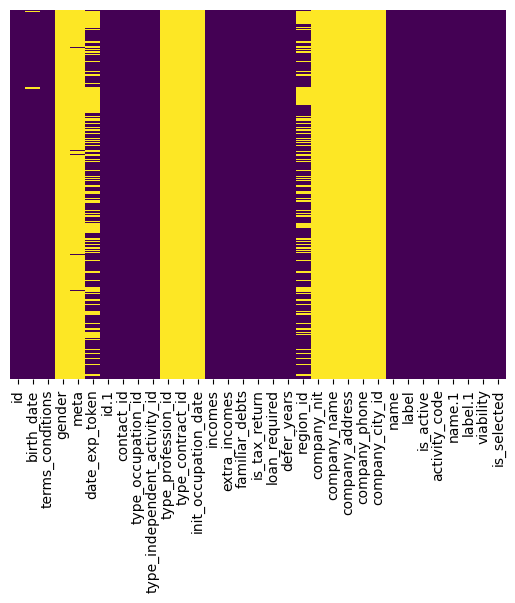

In [90]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

`No son utiles:` 
gender
meta
type_profession_id
type_contract_id
init_occupation_date
company_nit
company_name
company_address
company_phone
company_city_id

### Distribucion de las variables objetivo (viability) 

<Axes: xlabel='viability', ylabel='count'>

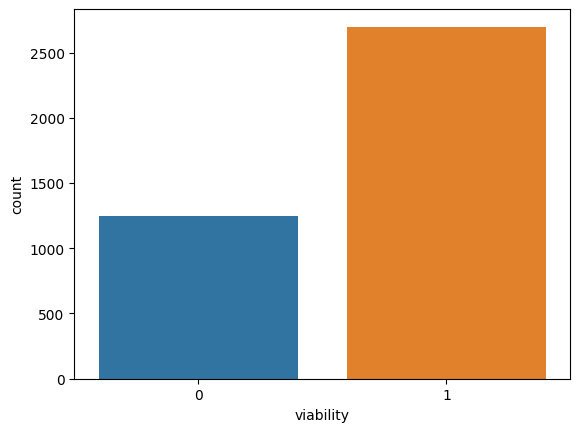

In [10]:
sns.countplot(x=habi_df['viability'])

El dataset es imbalanceado, por esta razon mas adelante usare Undersampling y metricas enfocadas a valores imbalanceados

<Axes: title={'center': 'Volumen de transacciones por usuario'}, xlabel='count'>

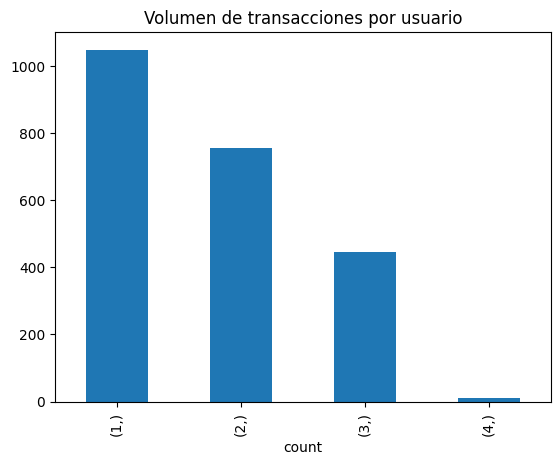

In [19]:
habi_df['id'].value_counts().to_frame().value_counts().plot.bar(title='Volumen de transacciones por usuario',)

<Axes: title={'center': 'Volumen de transacciones por usuario'}, xlabel='count'>

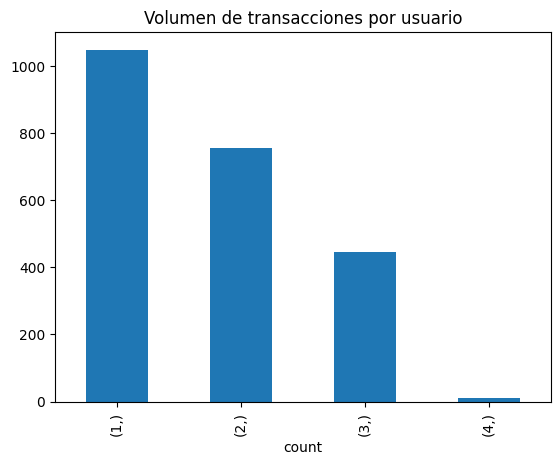

In [20]:
habi_df['id.1'].value_counts().to_frame().value_counts().plot.bar(title='Volumen de transacciones por usuario',)

In [92]:
ids_columns = ['id','id.1','loan_required','defer_years']
null_columns = ["gender",
    "meta",
    "type_profession_id",
    "type_contract_id",
    "init_occupation_date",
    "company_nit",
    "company_name",
    "company_address",
    "company_phone",
    "company_city_id"
    ]

habi_df = habi_df.drop(columns=ids_columns+null_columns)

# Verificar valores nulos 

<Axes: >

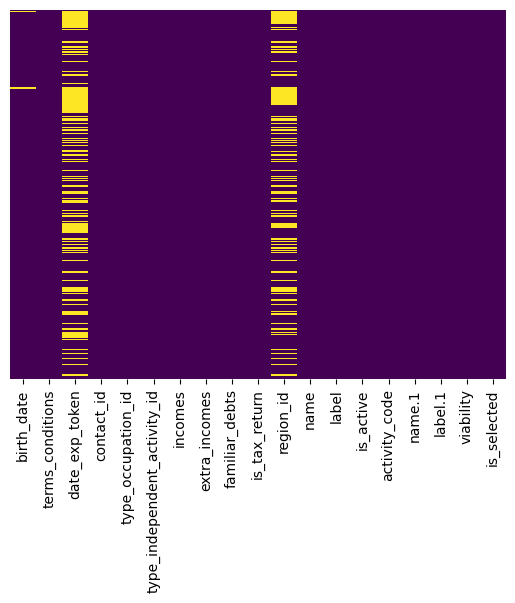

In [93]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [94]:
habi_df.head()

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,region_id,name,label,is_active,activity_code,name.1,label.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,1.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,11.0,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,NaN,"wholesale and retail, auto repair",Comercio Mayor/Menor; Reparación de Automotores,1,3,employee,Asalariado,1,1


In [95]:
habi_df[['name','label']].groupby(['name','label']).size() 

name                                               label                                             
agriculture, livestock, hunting, forestry fishing  Agricultura, Ganadería, Caza, Silvicultura y Pesca      66
association and repair activities                  Actividades de Asociación y Reparación                  47
manufacture                                        Industrias Manufactureras                              130
other personal services activities                 Otras Actividades de Servicios Personales              537
others                                             Otros                                                 1244
professional scientif and technical activities     Actividades Profesionales, Ciéntificas y Técnicas      777
real state activitys                               Actividades Inmobiliarias                              189
transport and storage                              Transporte y Almacenamiento                            169
wholesale and reta

In [96]:
habi_df[['name.1','label.1']].groupby(['name.1','label.1']).size() 


name.1       label.1      
employee     Asalariado        118
independent  Independiente    3825
retired      Pensionado          1
dtype: int64

In [97]:
repeated_columns = ["label",  'label.1' ]
habi_df = habi_df.drop(columns=repeated_columns)

* el dataset es inbalanceado

In [98]:
habi_df['viability'].value_counts()

viability
1    2698
0    1246
Name: count, dtype: int64

In [99]:
habi_df.head()

,birth_date,terms_conditions,date_exp_token,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,region_id,name,is_active,activity_code,name.1,viability,is_selected
0,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,1,0
1,1998-05-30,1,2022-11-25 23:13:29.0,1767,1,1,1500000,700000,0,0,26.0,"wholesale and retail, auto repair",1,3,employee,0,0
2,1984-07-08,0,2023-01-16 18:16:50.0,23963,1,1,4781830,0,0,1,1.0,"wholesale and retail, auto repair",1,3,employee,1,1
3,1985-02-14,0,NaN,23965,1,1,9000000,1000000,0,1,11.0,"wholesale and retail, auto repair",1,3,employee,1,1
4,1997-01-09,0,NaN,24370,1,1,8000000,0,0,1,NaN,"wholesale and retail, auto repair",1,3,employee,1,1


In [100]:
habi_df = habi_df[~habi_df.birth_date.isnull()]

# Feature Engineering

In [101]:
habi_df['has_extra_incomes'] = (habi_df.extra_incomes==0).astype(int)
habi_df['has_familiar_debts'] = (habi_df.familiar_debts==0).astype(int)
habi_df['has_region_id'] = ~habi_df.region_id.isnull()
habi_df['has_date_exp_token'] = ~habi_df.date_exp_token.isnull()

In [102]:
habi_df['date_exp_token'] = habi_df['date_exp_token'].fillna(method='ffill')
habi_df['region_id'] = habi_df['region_id'].fillna(0).astype(str)

## Extract time data

In [103]:
habi_df['birth_date'] = pd.to_datetime(habi_df['birth_date'],format='mixed',errors='coerce')
habi_df['birth_date'] = habi_df['birth_date'].fillna(habi_df['birth_date'].median())

In [104]:
habi_df['year_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.year
habi_df['month_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.month
habi_df['day_exp_token'] = pd.to_datetime(habi_df['date_exp_token']).dt.day

habi_df['year_birth'] = pd.to_datetime(habi_df['birth_date']).dt.year
habi_df['month_birth'] = pd.to_datetime(habi_df['birth_date']).dt.month
habi_df['day_birth'] = pd.to_datetime(habi_df['birth_date']).dt.day

habi_df = habi_df.drop(columns=['birth_date','date_exp_token'])

<Axes: >

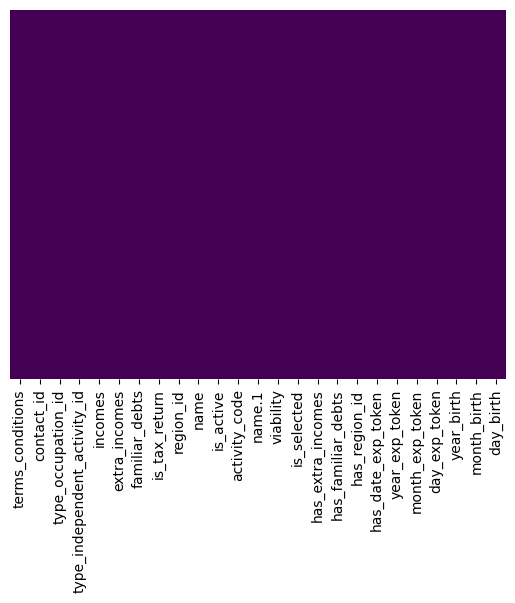

In [105]:
sns.heatmap(habi_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Undersampling

In [21]:
habi_df = habi_df.sample(frac=1,random_state=44)

# amount of fraud classes 492 rows.
viability_df = habi_df.loc[habi_df['viability'] == 1][:1246]
non_viability_df = habi_df.loc[habi_df['viability'] == 0]

normal_distributed_df = pd.concat([viability_df, non_viability_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,terms_conditions,contact_id,type_occupation_id,type_independent_activity_id,incomes,extra_incomes,familiar_debts,is_tax_return,region_id,name,...,has_extra_incomes,has_familiar_debts,has_region_id,has_date_exp_token,year_exp_token,month_exp_token,day_exp_token,year_birth,month_birth,day_birth
284,1,22942,3,1,10000000,0,0,1,6.0,"wholesale and retail, auto repair",...,1,1,True,True,2022,11,24,1982,10,23
58,1,14291,3,1,2800000,0,1000000,0,13.0,"wholesale and retail, auto repair",...,1,0,True,False,2023,4,5,1990,1,20
169,1,15943,3,1,25000000,0,0,1,2.0,"wholesale and retail, auto repair",...,1,1,True,False,2023,4,28,1996,3,13
141,1,15093,3,1,15000000,0,1500000,1,0.0,"wholesale and retail, auto repair",...,1,0,False,False,2023,4,5,1979,5,13
1618,1,27450,3,2,27000000,0,0,0,1.0,others,...,1,1,True,True,2023,3,6,1960,1,22


Distribution of the Classes in the subsample dataset
viability
1    0.502622
0    0.497378
Name: count, dtype: float64


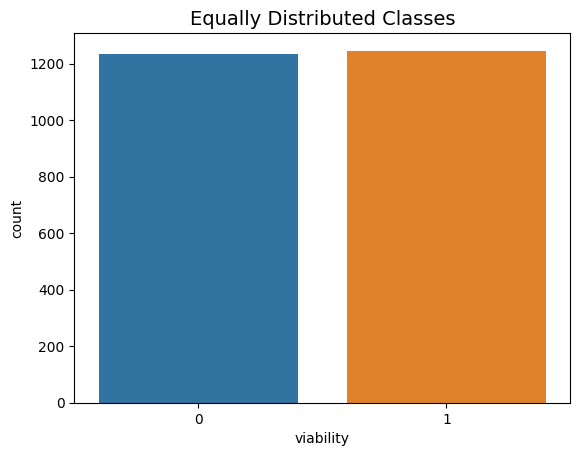

In [22]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['viability'].value_counts()/len(new_df))



sns.countplot(x='viability', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [106]:
habi_df.columns

Index(['terms_conditions', 'contact_id', 'type_occupation_id',
       'type_independent_activity_id', 'incomes', 'extra_incomes',
       'familiar_debts', 'is_tax_return', 'region_id', 'name', 'is_active',
       'activity_code', 'name.1', 'viability', 'is_selected',
       'has_extra_incomes', 'has_familiar_debts', 'has_region_id',
       'has_date_exp_token', 'year_exp_token', 'month_exp_token',
       'day_exp_token', 'year_birth', 'month_birth', 'day_birth'],
      dtype='object')

In [25]:
habi_df.to_excel('clean.xlsx',index=None)


In [107]:

def proba_plot(df:pd.DataFrame,feature:str):
    probabilities = df.groupby([feature, 'viability']).size() / df.groupby(feature).size()
    probabilities = probabilities.reset_index().rename(columns={0: 'Probability'})
    pivot_df = probabilities.pivot(index=feature, columns='viability', values='Probability')
    pivot_df.plot(kind='bar', stacked=False)
    plt.title('Probabilities of Class Combinations')
    plt.xlabel(feature)
    plt.ylabel('Probability')
    plt.show()

terms_conditions


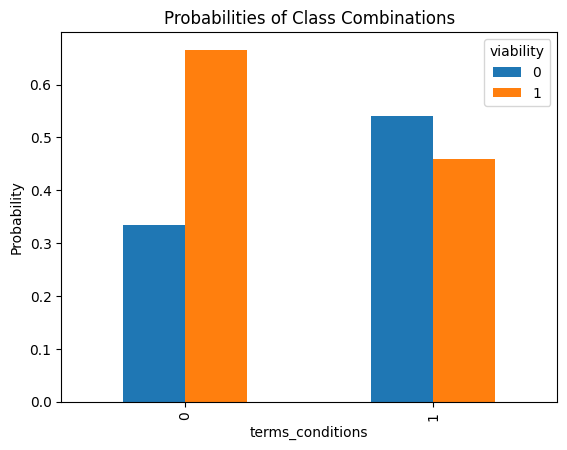

type_occupation_id


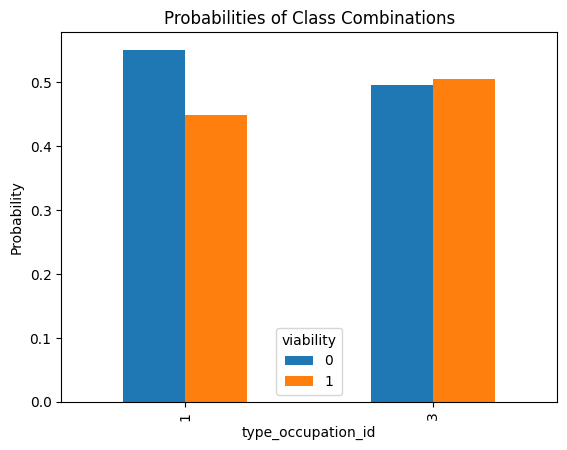

type_independent_activity_id


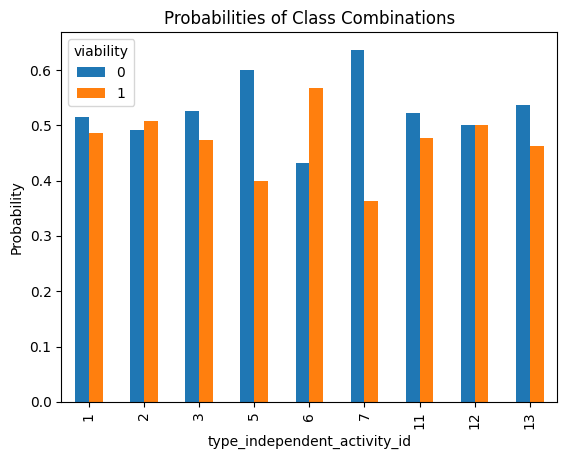

is_tax_return


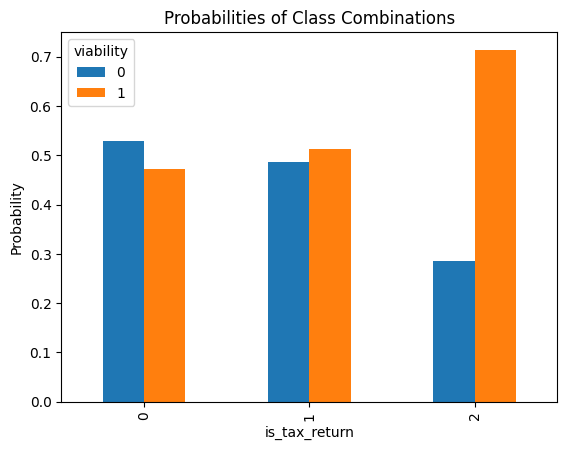

region_id


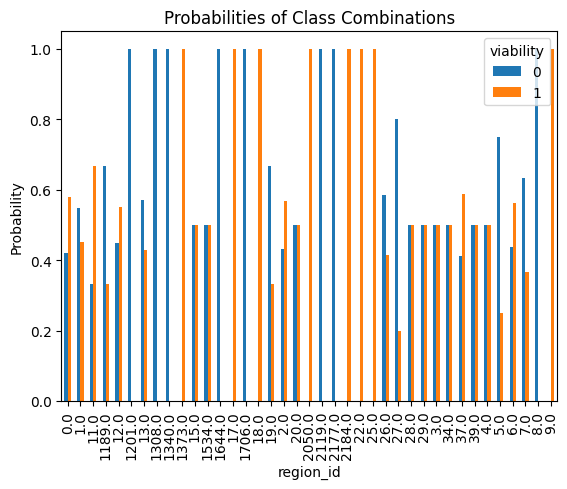

name


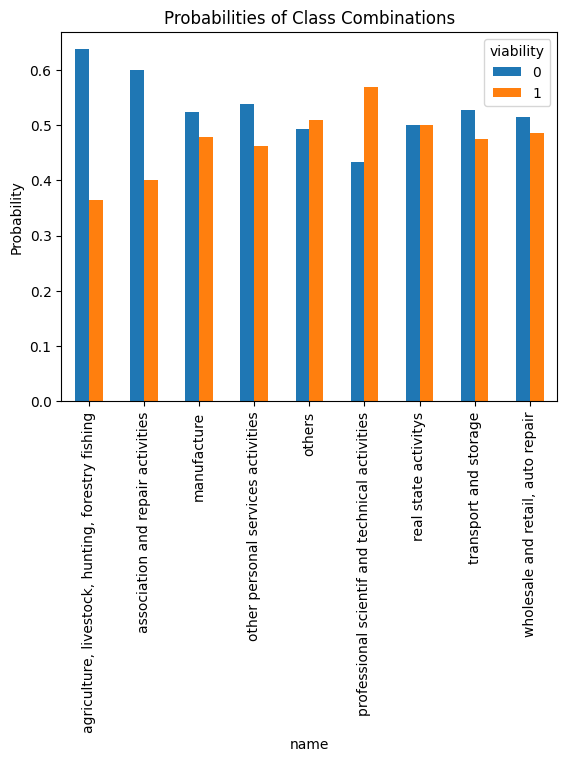

is_active


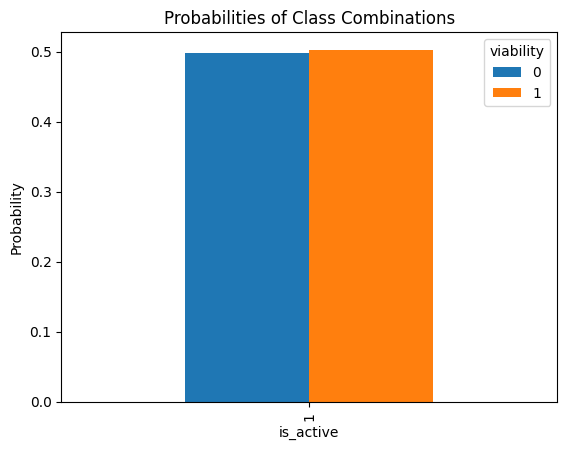

activity_code


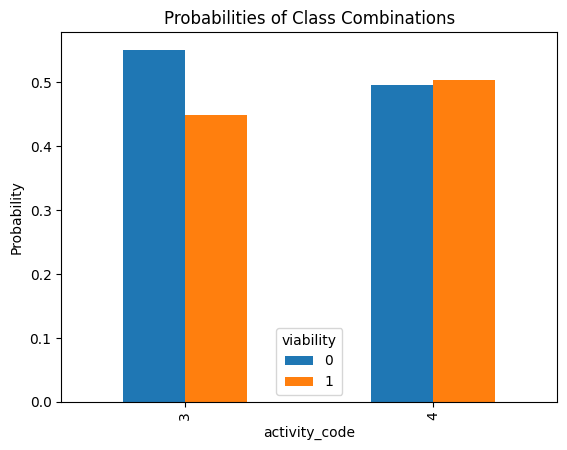

name.1


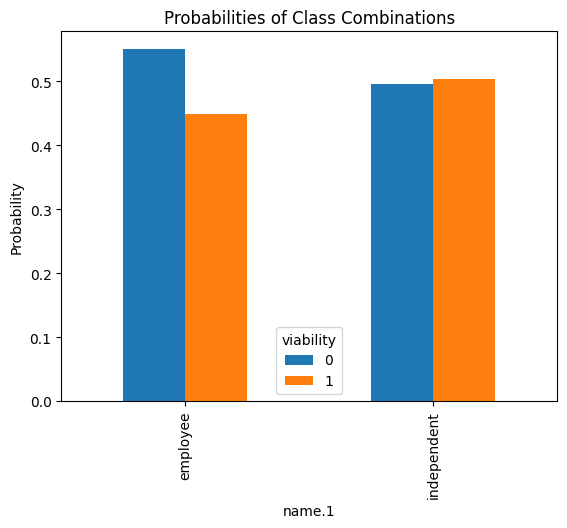

is_selected


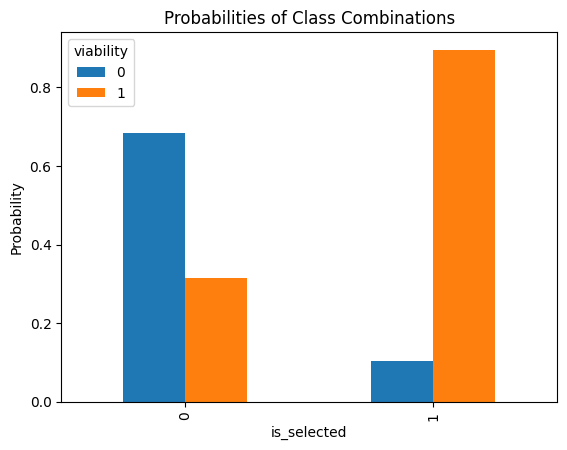

has_extra_incomes


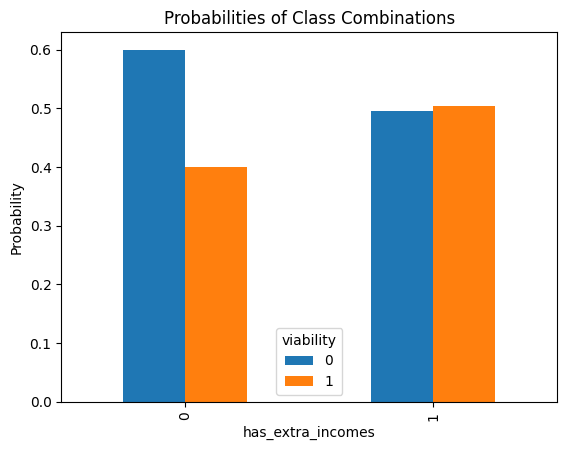

has_familiar_debts


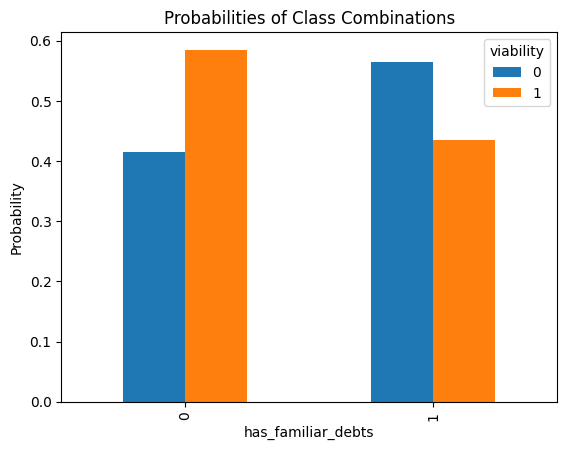

has_region_id


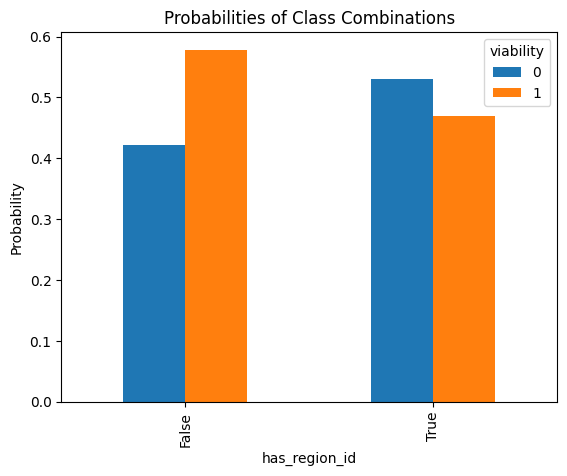

has_date_exp_token


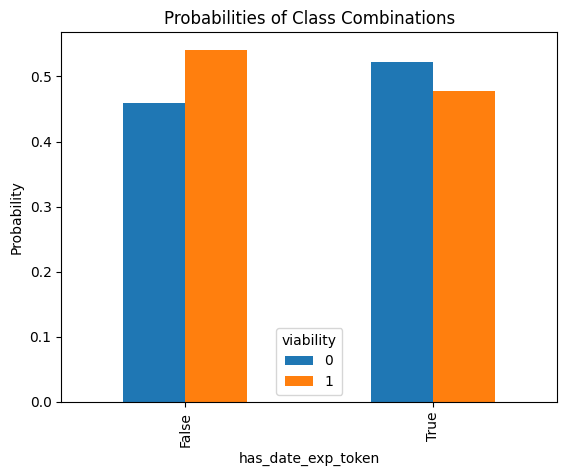

year_exp_token


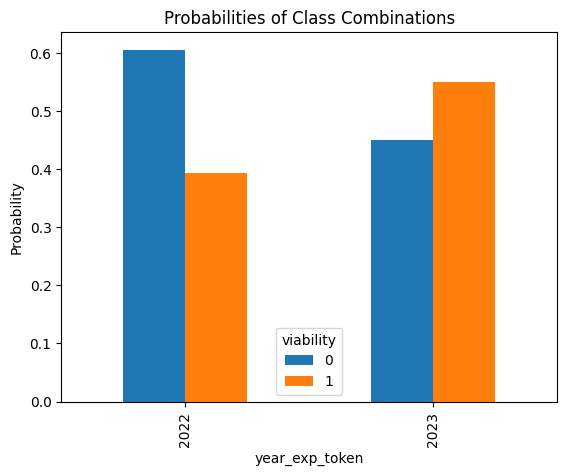

month_exp_token


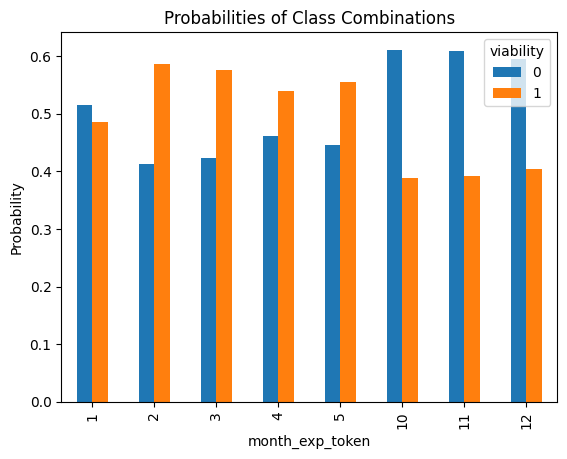

day_exp_token


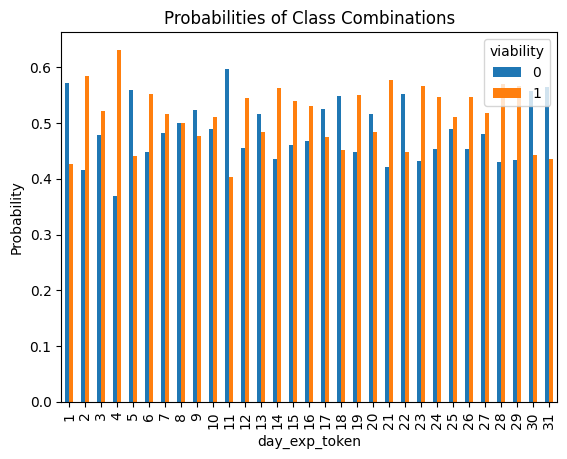

year_birth


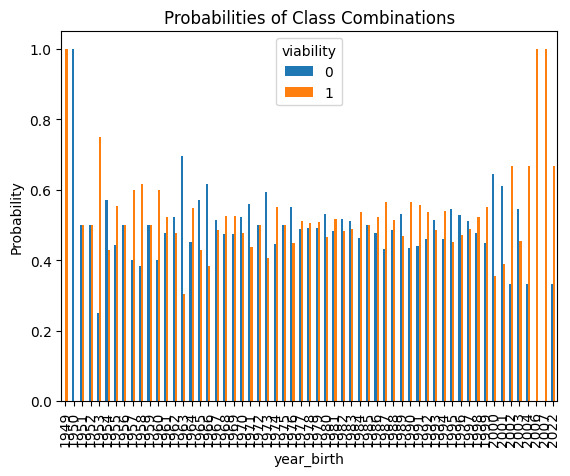

month_birth


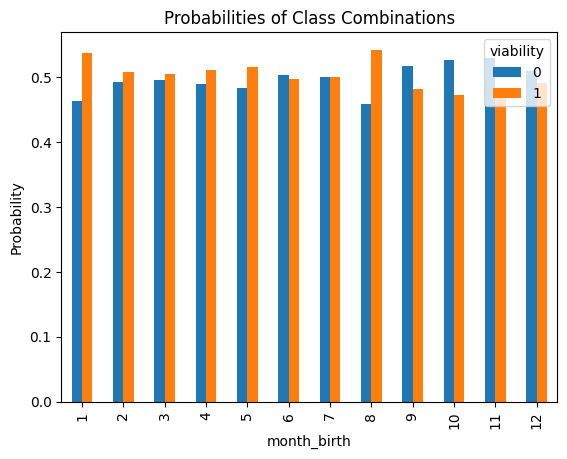

day_birth


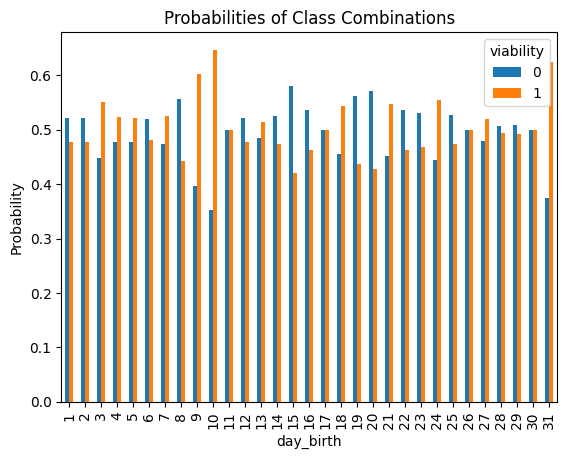

In [108]:
categorical = ['terms_conditions', 'type_occupation_id',
       'type_independent_activity_id',  'is_tax_return', 'region_id', 'name', 'is_active',
       'activity_code', 'name.1', 'is_selected',
       'has_extra_incomes', 'has_familiar_debts', 'has_region_id',
       'has_date_exp_token', 'year_exp_token', 'month_exp_token',
       'day_exp_token', 'year_birth', 'month_birth', 'day_birth']

for c in categorical:
    print(c)
    proba_plot(new_df,c)

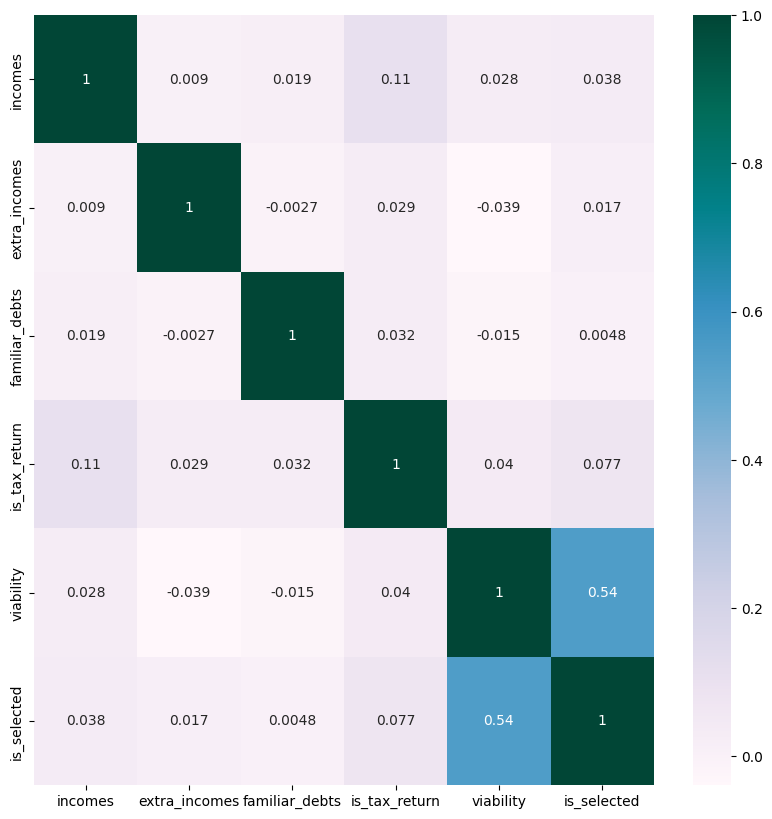

In [109]:
plt.figure(figsize=(10,10))
plt.rc('font', size=10)
hm=sns.heatmap((new_df[['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']].corr()),cmap="PuBuGn",annot=True)

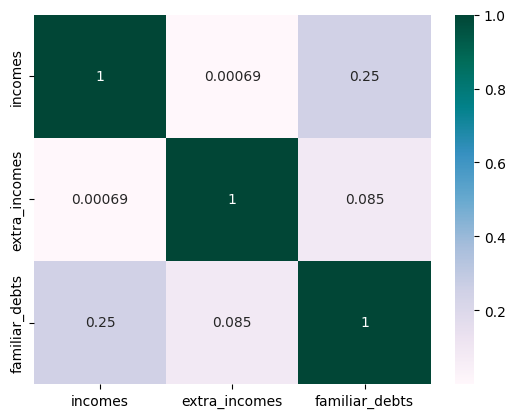

In [144]:
hm=sns.heatmap((out_df[['incomes','extra_incomes','familiar_debts']].corr()),cmap="PuBuGn",annot=True)


In [145]:
sns.pairplot(out_df[['incomes','extra_incomes','familiar_debts']])

KeyboardInterrupt: 

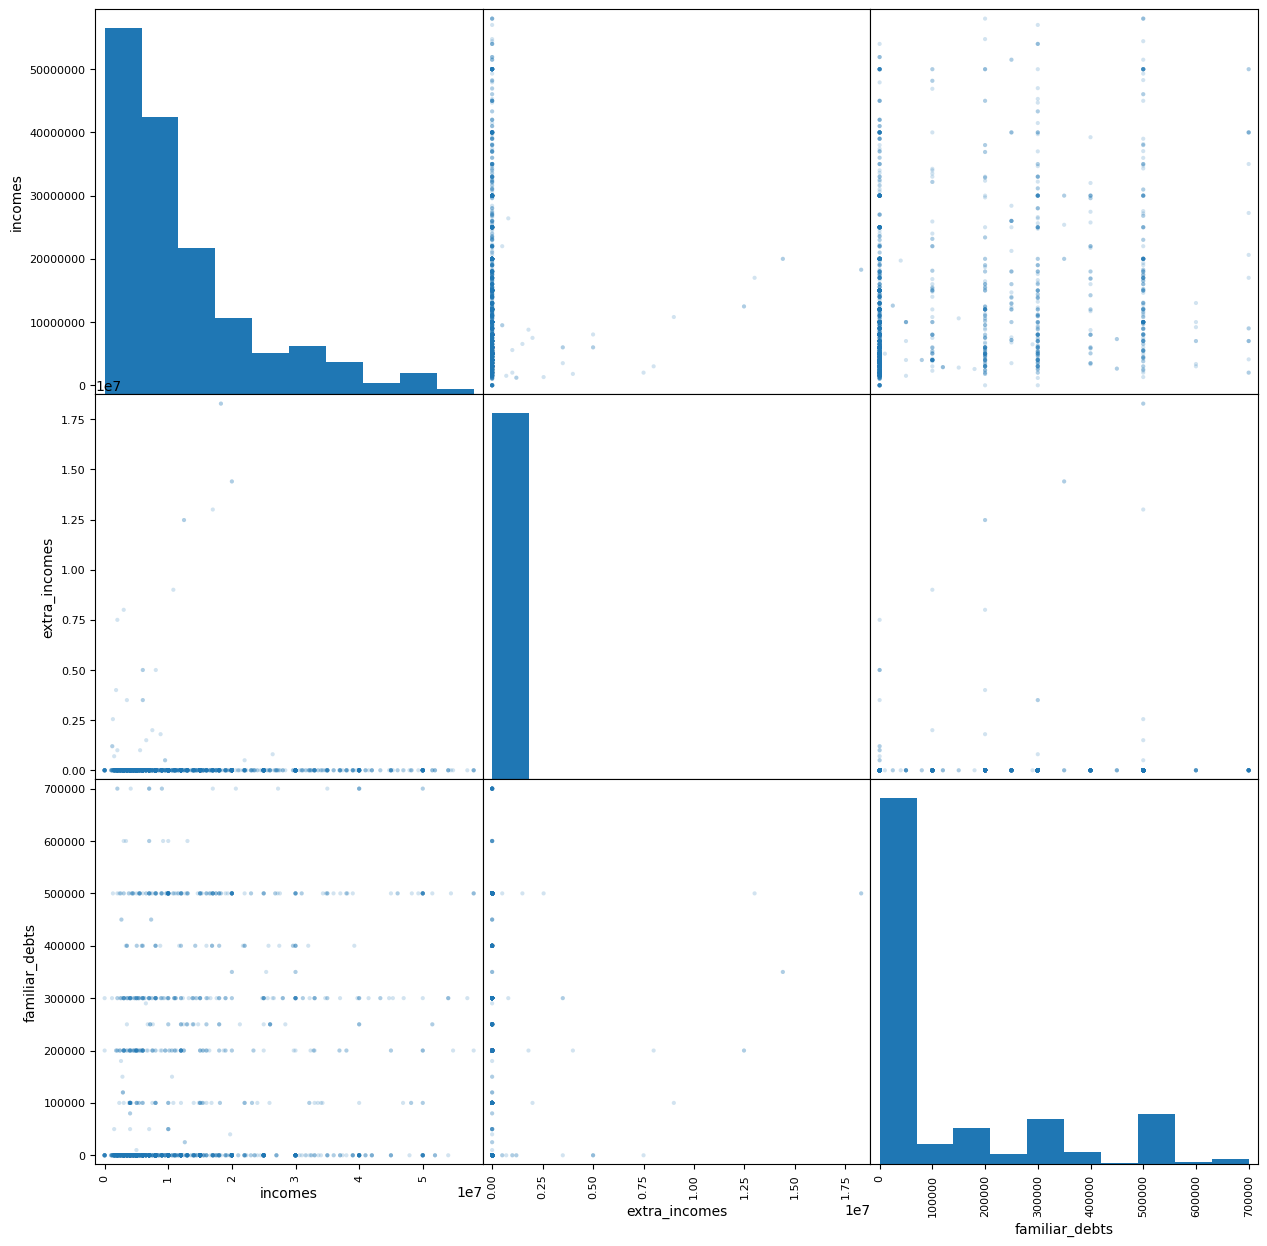

In [143]:
pd.plotting.scatter_matrix(out_df[['incomes','extra_incomes','familiar_debts']], alpha=0.2,figsize=(15,15))
print()

In [27]:
new_df.shape

(2479, 25)

(2257, 25)

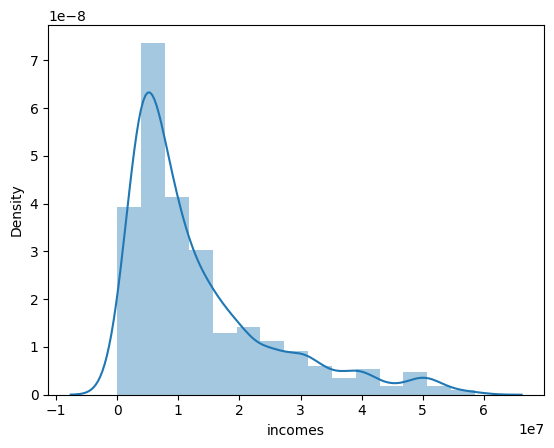

In [141]:
"['incomes','extra_incomes','familiar_debts','is_tax_return','viability','is_selected']"

out_df = new_df.copy()
#out_df['incomes'] = np.log1p(out_df['incomes'])
#out_df['extra_incomes'] = np.log1p(out_df['extra_incomes'])

q25, q75 = out_df['incomes'].quantile(0.25),out_df['incomes'].quantile(0.75)
iqr = q75 - q25
cut_off = iqr * 2
lower, upper = q25 - cut_off, q75 + cut_off

out_df = out_df[(out_df['incomes']>lower)&(out_df['incomes']<upper)]   

sns.distplot(out_df['incomes'],bins=15)

out_df.shape


-450000.0 750000.0


<Axes: xlabel='familiar_debts', ylabel='Density'>

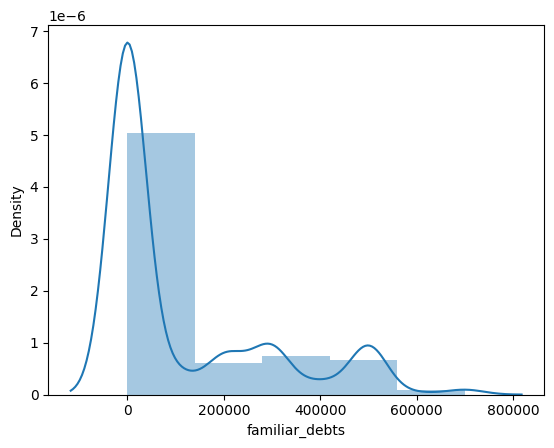

In [142]:
#out_df['familiar_debts'] = np.log1p(out_df['familiar_debts'])

q25, q75 = out_df['familiar_debts'].quantile(0.25),out_df['familiar_debts'].quantile(0.75)

iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper)

out_df = out_df[(out_df['familiar_debts']>lower)&(out_df['familiar_debts']<upper)] 


sns.distplot(out_df['familiar_debts'],bins=5)


In [113]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series,out_df['viability'])


mi = out_df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

is_selected                     0.162025
region_id                       0.016385
terms_conditions                0.014825
month_exp_token                 0.011259
has_familiar_debts              0.011206
year_exp_token                  0.009882
year_birth                      0.006760
day_exp_token                   0.006227
day_birth                       0.005205
has_region_id                   0.004909
name                            0.003479
type_independent_activity_id    0.003479
has_date_exp_token              0.001974
is_tax_return                   0.001056
month_birth                     0.000953
has_extra_incomes               0.000349
name.1                          0.000167
type_occupation_id              0.000167
activity_code                   0.000167
is_active                       0.000000
dtype: float64

In [ ]:
new_df

In [114]:
#'day_exp_token'
ohe = pd.get_dummies(out_df[['type_occupation_id','type_independent_activity_id','is_tax_return','region_id','name','activity_code','name.1','year_exp_token','month_exp_token',]].astype(str)).astype(int)
ohe

,type_occupation_id_1,type_occupation_id_3,type_independent_activity_id_1,type_independent_activity_id_11,type_independent_activity_id_12,type_independent_activity_id_13,type_independent_activity_id_2,type_independent_activity_id_3,type_independent_activity_id_5,type_independent_activity_id_6,...,year_exp_token_2022,year_exp_token_2023,month_exp_token_1,month_exp_token_10,month_exp_token_11,month_exp_token_12,month_exp_token_2,month_exp_token_3,month_exp_token_4,month_exp_token_5
284,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
58,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
169,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
141,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1618,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2785,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2698,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
726,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [115]:
merge = new_df[['terms_conditions','incomes','extra_incomes','familiar_debts','is_tax_return',
                'viability','is_selected','is_active','has_extra_incomes', 'has_familiar_debts',
                'has_region_id', 'has_date_exp_token']]
merge = pd.concat([merge.reset_index(drop=True),ohe.reset_index(drop=True)],axis=1)

# Train

In [131]:

# Extract feature and target arrays
X, y = merge.drop('viability', axis=1), merge['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=4, stratify=y)



In [133]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


# Define the objective function for Optuna
def objective(trial, xtrain,ytrain,xval,yval):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 10),
        'random_state': 42
    }
    
    # Create the XGBoost classifier
    xgb_cl = xgb.XGBClassifier(**params)
    
    # Fit the classifier
    xgb_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = xgb_cl.predict(xval)
    
    # Calculate roc_auc_score
    score = (f1_score(yval, preds)+accuracy_score(yval, preds))*0.5
    #roc_auc_score(yval, preds)
    
    return score


def objective_cv(trial):
    
    # Get the MNIST dataset.
    skf = StratifiedKFold(n_splits=5)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold,y_train_fold, x_val_fold,y_val_fold)
        score_list.append(score)
    return np.mean(score_list)

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=10)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

[I 2023-06-03 11:57:56,038] A new study created in memory with name: no-name-326967bc-20ce-4905-a993-59e4bd4b6aea
[I 2023-06-03 11:57:58,098] Trial 0 finished with value: 0.6895122716839074 and parameters: {'max_depth': 3, 'learning_rate': 0.01957530630913469, 'subsample': 0.7, 'colsample_bytree': 0.7, 'n_estimators': 892, 'gamma': 0.09238995154724983, 'reg_alpha': 7.852058440830674, 'reg_lambda': 7.169865399529202, 'min_child_weight': 3.123221273441885, 'scale_pos_weight': 0.9168108913981299}. Best is trial 0 with value: 0.6895122716839074.
[I 2023-06-03 11:57:59,904] Trial 1 finished with value: 0.6038352844644861 and parameters: {'max_depth': 15, 'learning_rate': 0.04655796077068043, 'subsample': 0.8, 'colsample_bytree': 0.6, 'n_estimators': 636, 'gamma': 0.8791142115715429, 'reg_alpha': 5.093300066073102, 'reg_lambda': 8.866161942633642, 'min_child_weight': 9.051571085957207, 'scale_pos_weight': 9.562553395751104}. Best is trial 0 with value: 0.6895122716839074.
[I 2023-06-03 11:58

Best Parameters: {'max_depth': 15, 'learning_rate': 0.0653540015867314, 'subsample': 0.6, 'colsample_bytree': 0.6, 'n_estimators': 541, 'gamma': 0.9892297725901452, 'reg_alpha': 0.9421176789945196, 'reg_lambda': 7.94496358463552, 'min_child_weight': 8.536125510345578, 'scale_pos_weight': 0.7502928647040141}
Best ROC AUC Score: 0.697650377438339


In [138]:
# Create the best classifier with the best parameters
best_classifier = xgb.XGBClassifier(**best_params)

# Fit the best classifier on the entire dataset
best_classifier.fit(X_train, y_train)

preds = best_classifier.predict(X_test)
    
    # Calculate roc_auc_score
score = roc_auc_score(y_test, preds)

score

0.756621628213258

[Text(0.5, 58.7222222222222, 'Predicted'),
 Text(70.72222222222221, 0.5, 'Actual')]

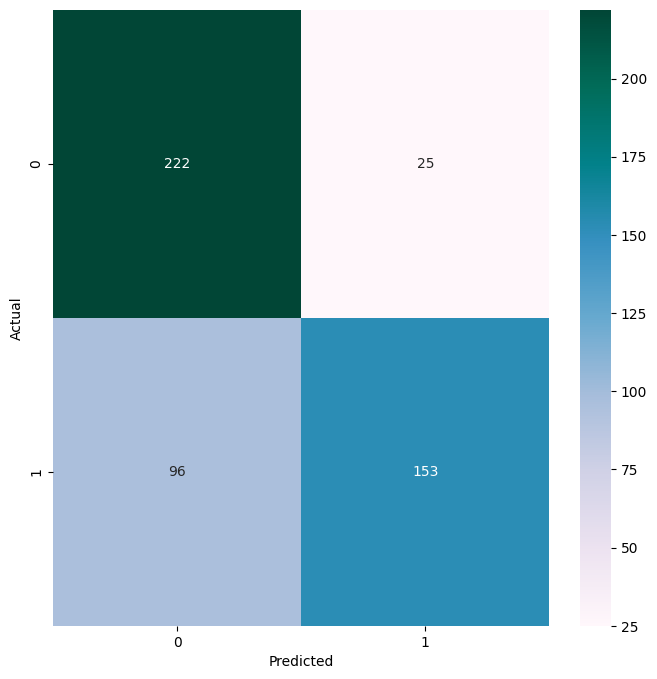

In [139]:

cm = confusion_matrix(y_test, preds,labels=[0,1])
cm_df = pd.DataFrame(cm ,columns=['0','1'],index=['0','1'])
plt.figure(figsize=(8, 8))
plot =sns.heatmap(cm_df,cmap="PuBuGn",annot=True,fmt='g')
plot.set(xlabel='Predicted', ylabel='Actual')

In [140]:
print(classification_report(y_test, preds, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.70      0.90      0.79       247
           1       0.86      0.61      0.72       249

    accuracy                           0.76       496
   macro avg       0.78      0.76      0.75       496
weighted avg       0.78      0.76      0.75       496



# Feature importance 

In [51]:
# Get feature importances
importances = best_classifier.feature_importances_

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

feature_importances.head(10)

,Feature,Importance
5,is_selected,0.508470
0,terms_conditions,0.046412
8,has_familiar_debts,0.029460
2,extra_incomes,0.024737
3,familiar_debts,0.019092
7,has_extra_incomes,0.012558
71,name_transport and storage,0.011784
13,type_independent_activity_id_1,0.011428
60,region_id_6.0,0.010981
18,type_independent_activity_id_3,0.010095


In [52]:
top_features = feature_importances[feature_importances['Importance']>0.01]['Feature'].to_list()
top_features

['is_selected',
 'terms_conditions',
 'has_familiar_debts',
 'extra_incomes',
 'familiar_debts',
 'has_extra_incomes',
 'name_transport and storage',
 'type_independent_activity_id_1',
 'region_id_6.0',
 'type_independent_activity_id_3']

In [53]:

partial = merge[top_features+['viability']]
# Extract feature and target arrays
X, y = partial.drop('viability', axis=1), partial['viability']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=4, stratify=y)


In [61]:


# Define the objective function for Optuna
def objective(trial, xtrain,ytrain,xval,yval):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.9, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 10),
        'random_state': 42
    }
    
    # Create the XGBoost classifier
    xgb_cl = xgb.XGBClassifier(**params)
    
    # Fit the classifier
    xgb_cl.fit(xtrain, ytrain)
    
    # Make predictions
    preds = xgb_cl.predict(xval)
    
    # Calculate roc_auc_score
    score = roc_auc_score(yval, preds)
    
    return score


def objective_cv(trial):
    
    # Get the MNIST dataset.
    skf = StratifiedKFold(n_splits=5)
    score_list = []
    
    for train_index, test_index in skf.split(X_test, y_test):
        x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
        score = objective(trial, x_train_fold,y_train_fold, x_val_fold,y_val_fold)
        score_list.append(score)
    return np.mean(score_list)

# Create an Optuna study object
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective_cv, n_trials=100)

# Get the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best ROC AUC Score:", best_score)

[I 2023-06-03 11:34:20,537] A new study created in memory with name: no-name-a7c4d75b-2f47-4746-82b5-a96b54e19440
[I 2023-06-03 11:34:21,432] Trial 0 finished with value: 0.5647199526634152 and parameters: {'max_depth': 18, 'learning_rate': 0.08248617479662175, 'subsample': 0.7, 'colsample_bytree': 0.9, 'n_estimators': 436, 'gamma': 0.3223336387474304, 'reg_alpha': 1.240506178702856, 'reg_lambda': 8.213113831871672, 'min_child_weight': 1.182570911900812, 'scale_pos_weight': 8.644500970032496}. Best is trial 0 with value: 0.5647199526634152.
[I 2023-06-03 11:34:21,564] Trial 1 finished with value: 0.5568556716275578 and parameters: {'max_depth': 14, 'learning_rate': 0.04934376064610698, 'subsample': 0.9, 'colsample_bytree': 0.9, 'n_estimators': 65, 'gamma': 0.17107500672935028, 'reg_alpha': 2.92092788944165, 'reg_lambda': 1.7962587913412875, 'min_child_weight': 7.568059380296023, 'scale_pos_weight': 8.572590072164187}. Best is trial 0 with value: 0.5647199526634152.
[I 2023-06-03 11:34:

Best Parameters: {'max_depth': 19, 'learning_rate': 0.02032222252192089, 'subsample': 0.9, 'colsample_bytree': 0.9, 'n_estimators': 249, 'gamma': 0.7508315736850121, 'reg_alpha': 5.782179019910213, 'reg_lambda': 2.856524938375852, 'min_child_weight': 9.97839261462123, 'scale_pos_weight': 1.5878481635186081}
Best ROC AUC Score: 0.7486256068800781


In [62]:
# Create the best classifier with the best parameters
best_classifier = xgb.XGBClassifier(**best_params)

# Fit the best classifier on the entire dataset
best_classifier.fit(X_train, y_train)

preds = best_classifier.predict(X_test)
    
    # Calculate roc_auc_score
score = roc_auc_score(y_test, preds)

score

0.7302283566989449

In [63]:
y_pred_proba = best_classifier.predict_proba(X_test)[::,1]
preds = (y_pred_proba>0.5).astype(int)

print(classification_report(y_test, preds, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.70      0.80      0.75       370
           1       0.77      0.66      0.71       374

    accuracy                           0.73       744
   macro avg       0.73      0.73      0.73       744
weighted avg       0.74      0.73      0.73       744



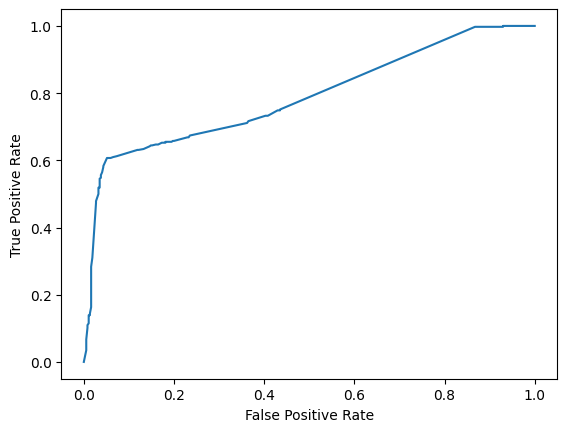

In [64]:
from sklearn import metrics

y_pred_proba = best_classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()